In [1]:
import theano as thno
import theano.tensor as T

thno.config.gcc.cxxflags = "-Wno-c++11-narrowing"

%matplotlib inline
from pathlib import Path
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
# from mlxtend.plotting import plot_confusion_matrix

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML
from itertools import combinations
 
%matplotlib inline


In [4]:
df = pd.read_csv('SAHeart.csv').drop(columns=['row.names'])
df['famhist'] = df['famhist'].apply(lambda row: 1 if row == 'Present' else 0)


expert_training_data = df[0:100]
training_data = df[100:400]
test_data = df[400:]

# initializing lista
column_list = list(df.columns[:-1])
all_pairs = list(combinations(column_list, 7))
from sklearn import tree

classifier_list = {}

for pair in all_pairs:
    clf = tree.DecisionTreeClassifier(max_depth=4)
    clf = clf.fit(expert_training_data[[pair[0], pair[1]]], expert_training_data['chd'])
    classifier_list[pair] = clf

for expert in all_pairs:
    clf = classifier_list[expert]
    
    df['Expert_'+str(expert)+'_0'] = clf.predict(df[[expert[0], expert[1]]]) == 0
    df['Expert_'+str(expert)+'_1'] = clf.predict(df[[expert[0], expert[1]]]) == 1
    df['Expert_'+str(expert)+'_0'] = df['Expert_'+str(expert)+'_0'].apply(lambda row: 1 if row else 0)
    df['Expert_'+str(expert)+'_1'] = df['Expert_'+str(expert)+'_1'].apply(lambda row: 1 if row else 0)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = df[100:400].copy().reset_index(drop=True)
training_data[column_list] = scaler.fit_transform(training_data[column_list])

test = df[400:].copy().reset_index(drop=True)
test[column_list] = scaler.transform(test[column_list])

In [5]:
def get_logistic_model(training_data_, prior):
    if prior is not None:
        intercept = pm.Normal('intercept', prior['intercept'], sd=1)
        beta_1_model = pm.Normal('beta_1', prior['beta_1'], sd=1)
        beta_2_model = pm.Normal('beta_2', prior['beta_2'], sd=1)
        beta_3_model = pm.Normal('beta_3', prior['beta_3'], sd=1)
        beta_4_model = pm.Normal('beta_4', prior['beta_4'], sd=1)
        beta_5_model = pm.Normal('beta_5', prior['beta_5'], sd=1)
        beta_6_model = pm.Normal('beta_6', prior['beta_6'], sd=1)
        beta_7_model = pm.Normal('beta_7', prior['beta_7'], sd=1)
        beta_8_model = pm.Normal('beta_8', prior['beta_8'], sd=1)
        beta_9_model = pm.Normal('beta_9', prior['beta_9'], sd=1)
    else:
        intercept = pm.Normal('intercept', 0, sd=1)
        beta_1_model = pm.Normal('beta_1', 0, sd=1)
        beta_2_model = pm.Normal('beta_2', 0, sd=1)
        beta_3_model = pm.Normal('beta_3', 0, sd=1)
        beta_4_model = pm.Normal('beta_4', 0, sd=1)
        beta_5_model = pm.Normal('beta_5', 0, sd=1)
        beta_6_model = pm.Normal('beta_6', 0, sd=1)
        beta_7_model = pm.Normal('beta_7', 0, sd=1)
        beta_8_model = pm.Normal('beta_8', 0, sd=1)
        beta_9_model = pm.Normal('beta_9', 0, sd=1)
    
    likelihood = pm.invlogit(
        intercept + 
        beta_1_model * training_data_[:,0] + 
        beta_2_model * training_data_[:,1] + 
        beta_3_model * training_data_[:,2] + 
        beta_4_model * training_data_[:,3] + 
        beta_5_model * training_data_[:,4] + 
        beta_6_model * training_data_[:,5] + 
        beta_7_model * training_data_[:,6] + 
        beta_8_model * training_data_[:,7] + 
        beta_9_model * training_data_[:,8]
    )
    return likelihood

In [6]:
def get_expert_model(training_data_, expert_features, expert_num, prior):
    if prior is not None:
        intercept_expert1 = pm.Normal('intercept_expert'+str(expert_num), prior['intercept_expert'+str(expert_num)], sd=1)
        beta_1_expert1 = pm.Normal('beta1_expert'+str(expert_num), prior['beta1_expert'+str(expert_num)], sd=1)
        beta_2_expert1 = pm.Normal('beta2_expert'+str(expert_num), prior['beta2_expert'+str(expert_num)], sd=1)
    else:
        intercept_expert1 = pm.Normal('intercept_expert'+str(expert_num), 0, sd=1)
        beta_1_expert1 = pm.Normal('beta1_expert'+str(expert_num), 0, sd=1)
        beta_2_expert1 = pm.Normal('beta2_expert'+str(expert_num), 0, sd=1)
        
    likelihood_expert = pm.invlogit(
        intercept_expert1 + 
        beta_1_expert1 * training_data_[:,0] + 
        beta_2_expert1 * training_data_[:,1]
    )
    return likelihood_expert

In [7]:
num_runs = 1
prior_list = []

for run_num in range(num_runs):
    index = run_num*training_data.shape[0]//num_runs
    index_next = (run_num+1)*training_data.shape[0]//num_runs

#     X_shared = theano.shared(training_data[index:index_next])
    prior = None
    
    with pm.Model() as logistic_model:
        X_shared1 = pm.Data('data', training_data.iloc[index:index_next,:])
        # random variables for coefficients with
        mu_model = get_logistic_model(X_shared1, prior)
#         mu_model = pm.Bernoulli(name='logit_model', p=likelihood, observed=training_data.chd.iloc[index:index_next])

        expert_num = 1
        expert_features = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
        X_shared2 = pm.Data('data2', training_data.loc[index:index_next-1, expert_features])
        mu_expert1 = get_expert_model(X_shared2, expert_features, expert_num, prior)
#         mu_expert1 = pm.Bernoulli(name='logit_expert'+str(expert_num), p=likelihood_expert, observed=training_data.chd.iloc[index:index_next])

        expert_num = 10
        expert_features = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
        X_shared3 = pm.Data('data3', training_data.loc[index:index_next-1, expert_features])
        mu_expert2 = get_expert_model(X_shared3, expert_features, expert_num, prior)
#         mu_expert2 = pm.Bernoulli(name='logit_expert'+str(expert_num), p=likelihood_expert, observed=training_data.chd.iloc[index:index_next])

        expert_num = 20
        expert_features = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
        X_shared4 = pm.Data('data4', training_data.loc[index:index_next-1, expert_features])
        mu_expert3 = get_expert_model(X_shared4, expert_features, expert_num, prior)
#         mu_expert3 = pm.Bernoulli(name='logit_expert'+str(expert_num), p=likelihood_expert, observed=training_data.chd.iloc[index:index_next])

        expert_num = 30
        expert_features = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
        X_shared5 = pm.Data('data5', training_data.loc[index:index_next-1, expert_features])
        mu_expert4 = get_expert_model(X_shared5, expert_features, expert_num, prior)
#         mu_expert4 = pm.Bernoulli(name='logit_expert'+str(expert_num), p=likelihood_expert, observed=training_data.chd.iloc[index:index_next])

        frac = pm.Dirichlet("frac", a=np.ones(5))
        tau = pm.Normal('threshold', 0, sd=1)

        prediction = frac[0]*mu_model + frac[1]*mu_expert1 + frac[2]*mu_expert2 + frac[3]*mu_expert3 + frac[4]*mu_expert4 - tau
        prediction = pm.invprobit(prediction)

        final_model = pm.Bernoulli(name='logit', p=prediction, observed=training_data.chd.iloc[index:index_next])
    
        manual_map_estimate = pm.find_MAP()
        trace = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=4)
    ppc = pm.sample_ppc(trace, samples=1000, model=logistic_model)
    y_score = np.mean(ppc['logit'], axis=0)
    pred_scores = dict(y_true=training_data['chd'].iloc[index:index_next] , y_score=y_score)
    print(roc_auc_score(**pred_scores))
    
    
    expert_num = 1
    expert_features1 = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
    
    expert_num = 10
    expert_features2 = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
    
    expert_num = 20
    expert_features3 = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
    
    expert_num = 30
    expert_features4 = ['Expert_'+str(all_pairs[expert_num])+'_0', 'Expert_'+str(all_pairs[expert_num])+'_1']
    
    with logistic_model:
        pm.set_data({
            "data": test,
            "data2": test[expert_features1],
            "data3": test[expert_features2],
            "data4": test[expert_features3],
            "data5": test[expert_features4],

        }, model=logistic_model)

        ppc_test = pm.sample_ppc(trace, samples=1000, model=logistic_model)
        y_score = np.mean(ppc_test['logit'], axis=0)
        pred_scores = dict(y_true=test['chd'], y_score=y_score)
        print(roc_auc_score(**pred_scores))

    
    prior_list.append(manual_map_estimate)
    prior = manual_map_estimate
    

ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

logp = -184.69, ||grad|| = 0.055984: 100%|████| 73/73 [00:00<00:00, 1923.98it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_in

0.7797792124587255


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 377.73it/s]

0.7424242424242424


In [9]:
# pm.model_to_graphviz(logistic_model).save('System_full.dot')

# pm.model_to_graphviz(logistic_model).save('seperate_dynamic_priors.dot')
precision, recall, ts = precision_recall_curve(y_true=test['chd'], probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})
f1 = pd.Series({t: f1_score(y_true=test['chd'], y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()
f1[best_threshold]

0.6451612903225806

In [7]:
prior_list

[{'intercept': array(-1.88231739),
  'beta_1': array(1.77715614),
  'beta_2': array(5.48345059),
  'beta_3': array(1.57767892),
  'beta_4': array(4.44143398),
  'beta_5': array(6.64028025),
  'beta_6': array(3.60343244),
  'beta_7': array(0.29527758),
  'beta_8': array(-1.12898931),
  'beta_9': array(6.29574186),
  'intercept_expert1': array(-0.00926058),
  'beta1_expert1': array(0.01294347),
  'beta2_expert1': array(-0.02220405),
  'intercept_expert10': array(-0.00926978),
  'beta1_expert10': array(0.01288373),
  'beta2_expert10': array(-0.0221535),
  'intercept_expert20': array(-0.0092971),
  'beta1_expert20': array(0.01270666),
  'beta2_expert20': array(-0.02200376),
  'intercept_expert30': array(-0.00949043),
  'beta1_expert30': array(0.01263442),
  'beta2_expert30': array(-0.02212485),
  'frac_stickbreaking__': array([12.79797185,  0.03278434,  0.04360672,  0.06503175]),
  'threshold': array(0.94736945),
  'frac': array([9.99988935e-01, 2.83492248e-06, 2.82381582e-06, 2.79119469e-

In [38]:
with logistic_model:
        pm.set_data({
            "data": test,
            "data2": test[expert_features1],
            "data3": test[expert_features2],
            "data4": test[expert_features3],
            "data5": test[expert_features4],

        }, model=logistic_model)
        y_test = pm.sample_posterior_predictive(trace)
        print(y_test)

100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 612.37it/s]

{'logit_model': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]]), 'logit_expert1': array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]), 'logit_expert10': array([[0, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]), 'logit_expert20': array([[0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]]), 'logit_expert30': array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 

In [40]:
# help(logistic_model)
# logistic_model.__getstate__()
y_test['logit_expert1'].shape

(4000, 40)

In [42]:
test.shape

(62, 82)

In [53]:
import pymc3 as pm

def get_va1l():
    return pm.Normal('beta', 0, 1)

def get_val2(x, beta, observed):
    x = x.get_value()
    return pm.Normal('obs', x * beta, 1, observed=y)

with pm.Model() as model:
    x = pm.Data('x', [1., 2., 3.])
    y = pm.Data('y', [1., 2., 3.])
    beta = get_va1l()
    obs = get_val2(x, beta, y)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:09<00:00, 841.27draws/s]


In [54]:
with model:
    pm.set_data({'x': [5., 6., 39.]})
    y_test = pm.sample_posterior_predictive(trace)
    

100%|██████████████████████████████████████| 4000/4000 [00:11<00:00, 352.87it/s]


In [56]:
y_test['obs'].mean(axis=0)

array([0.92403872, 1.87470077, 2.77066831])

In [26]:
with logistic_model:
    trace = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)
    pm.set_data({
            "data": test,
            "data2": test[expert_features1],
            "data3": test[expert_features2],
            "data4": test[expert_features3],
            "data5": test[expert_features4],

        }, model=logistic_model)
    ppc_test = pm.sample_posterior_predictive(trace, samples=500, )
    y_score = np.mean(ppc_test['logit'], axis=0)
    pred_scores = dict(y_true=test['chd'], y_score=y_score)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 3 jobs)
NUTS: [threshold, frac, beta2_expert30, beta1_expert30, intercept_expert30, beta2_expert20, beta1_expert20, intercept_expert20, beta2_expert10, beta1_expert10, intercept_expert10, beta2_expert1, beta1_expert1, intercept_ex

In [36]:
with logistic_model:
    pm.set_data({
            "data": test,
            "data2": test[expert_features1],
            "data3": test[expert_features2],
            "data4": test[expert_features3],
            "data5": test[expert_features4],

        }, model=logistic_model)
    ppc_test = pm.sample_posterior_predictive(trace, samples=500)
    y_score = np.mean(ppc_test['logit'], axis=0)
    pred_scores = dict(y_true=test['chd'], y_score=y_score)
    

/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|████████████████████████████████████████| 500/500 [00:00<00:00, 592.23it/s]


In [37]:
pred_scores = dict(y_true=test['chd'], y_score=y_score)
pred_scores

{'y_true': 0     0
 1     0
 2     1
 3     1
 4     0
      ..
 57    0
 58    1
 59    0
 60    0
 61    1
 Name: chd, Length: 62, dtype: int64,
 'y_score': array([0.268, 0.318, 0.276, 0.284, 0.392, 0.3  , 0.334, 0.41 , 0.28 ,
        0.352, 0.29 , 0.314, 0.334, 0.296, 0.244, 0.35 , 0.342, 0.3  ,
        0.286, 0.37 , 0.288, 0.346, 0.328, 0.344, 0.324, 0.308, 0.364,
        0.36 , 0.312, 0.402, 0.358, 0.372, 0.306, 0.276, 0.29 , 0.354,
        0.302, 0.344, 0.328, 0.284])}

In [35]:
ppc_test['logit_model'].shape

(500, 40)

In [17]:
test.shape

(62, 82)

# Extra Stuff

In [26]:
prior_list

[{'intercept': array(-1.08709829),
  'beta_1': array(0.05646701),
  'beta_2': array(0.46280016),
  'beta_3': array(-0.02704541),
  'beta_4': array(0.66484329),
  'beta_5': array(0.84879851),
  'beta_6': array(0.77568386),
  'beta_7': array(0.19397482),
  'beta_8': array(0.06600832),
  'beta_9': array(0.00903476),
  'intercept_expert1': array(-0.40116677),
  'beta1_expert1': array(-0.64741007),
  'beta2_expert1': array(0.2462433),
  'intercept_expert10': array(-0.40116677),
  'beta1_expert10': array(-0.64741007),
  'beta2_expert10': array(0.2462433),
  'intercept_expert20': array(-0.40116677),
  'beta1_expert20': array(-0.64741007),
  'beta2_expert20': array(0.2462433),
  'intercept_expert30': array(-0.41737492),
  'beta1_expert30': array(-0.49803159),
  'beta2_expert30': array(0.08065667),
  'frac_stickbreaking__': array([ 0.0000000e+00, -1.1192651e-17,  1.5806177e-16,  0.0000000e+00]),
  'threshold': array(0.79776623),
  'frac': array([0.2, 0.2, 0.2, 0.2, 0.2])},
 {'intercept': array(

TypeError: No model on context stack, which is needed to instantiate a data container. Add variable inside a 'with model:' block.

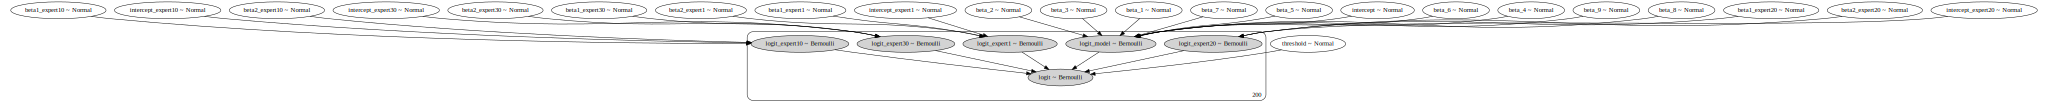

In [118]:
pm.model_to_graphviz(logistic_model)

In [155]:
with logistic_model:
    manual_map_estimate = pm.find_MAP()

ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

logp = -680.51, ||grad|| = 0.039717: 100%|████| 16/16 [00:00<00:00, 2062.92it/s]


In [149]:
with logistic_model:
    manual_map_estimate = pm.find_MAP()

ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

logp = nan, ||grad|| = 0: 100%|███████████████| 42/42 [00:00<00:00, 3380.23it/s]


In [156]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

manual_map_estimate


{'intercept': array(-0.89056648),
 'beta_1': array(0.22607279),
 'beta_2': array(0.31199064),
 'beta_3': array(0.40978125),
 'beta_4': array(0.18629858),
 'beta_5': array(0.47078801),
 'beta_6': array(0.5447846),
 'beta_7': array(-0.12916959),
 'beta_8': array(-0.14331121),
 'beta_9': array(0.60243381),
 'intercept_expert1': array(-0.31813261),
 'beta1_expert1': array(-0.70475279),
 'beta2_expert1': array(0.38662019),
 'intercept_expert10': array(-0.31813261),
 'beta1_expert10': array(-0.70475279),
 'beta2_expert10': array(0.38662019),
 'intercept_expert20': array(-0.31813261),
 'beta1_expert20': array(-0.70475279),
 'beta2_expert20': array(0.38662019),
 'intercept_expert30': array(-0.30682784),
 'beta1_expert30': array(-0.65696008),
 'beta2_expert30': array(0.35013224),
 'frac_stickbreaking__': array([5.88457982e-16, 5.28383747e-16, 2.24623451e-16, 0.00000000e+00]),
 'threshold': array(0.80367714),
 'frac': array([0.2, 0.2, 0.2, 0.2, 0.2])}

In [132]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

manual_map_estimate


{'intercept': array(-0.89056648),
 'beta_1': array(0.22607279),
 'beta_2': array(0.31199064),
 'beta_3': array(0.40978125),
 'beta_4': array(0.18629858),
 'beta_5': array(0.47078801),
 'beta_6': array(0.5447846),
 'beta_7': array(-0.12916959),
 'beta_8': array(-0.14331121),
 'beta_9': array(0.60243381),
 'intercept_expert1': array(-0.31813261),
 'beta1_expert1': array(-0.70475279),
 'beta2_expert1': array(0.38662019),
 'intercept_expert10': array(-0.31813261),
 'beta1_expert10': array(-0.70475279),
 'beta2_expert10': array(0.38662019),
 'intercept_expert20': array(-0.31813261),
 'beta1_expert20': array(-0.70475279),
 'beta2_expert20': array(0.38662019),
 'intercept_expert30': array(-0.30682784),
 'beta1_expert30': array(-0.65696008),
 'beta2_expert30': array(0.35013224),
 'frac_stickbreaking__': array([5.88457982e-16, 5.28383747e-16, 2.24623451e-16, 0.00000000e+00]),
 'threshold': array(0.80367714),
 'frac': array([0.2, 0.2, 0.2, 0.2, 0.2])}

In [133]:
with logistic_model:
    trace = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 3 jobs)
NUTS: [threshold, frac, beta2_expert30, beta1_expert30, intercept_expert30, beta2_expert20, beta1_expert20, intercept_expert20, beta2_expert10, beta1_expert10, intercept_expert10, beta2_expert1, beta1_expert1, intercept_ex

In [134]:
ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)

/var/folders/zd/kdgn2w_s28q2d2gnvdb0dd6w0000gn/T/ipykernel_21789/928312837.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)
/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|████████████████████████████████████████| 500/500 [00:01<00:00, 459.61it/s]


In [135]:
y_score = np.mean(ppc['logit'], axis=0)
pred_scores = dict(y_true=training_data['chd'] , y_score=y_score)
roc_auc_score(**pred_scores)


0.7214846775085739

In [136]:
y_score = np.mean(ppc['logit_model'], axis=0)
pred_scores = dict(y_true=training_data['chd'] , y_score=y_score)
roc_auc_score(**pred_scores)


0.8023564553601062

In [95]:
y_score = np.mean(ppc['logit_expert4'], axis=0)
pred_scores = dict(y_true=training_data['chd'] , y_score=y_score)
roc_auc_score(**pred_scores)


KeyError: 'logit_expert4'

In [50]:
with logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

logp = -736.49, ||grad|| = 0.079045: 100%|████| 15/15 [00:00<00:00, 3557.71it/s]


In [68]:
manual_map_estimate

{'intercept': array(-0.89054335),
 'beta_1': array(0.2259892),
 'beta_2': array(0.3119402),
 'beta_3': array(0.40986637),
 'beta_4': array(0.18624801),
 'beta_5': array(0.47074787),
 'beta_6': array(0.54471088),
 'beta_7': array(-0.12912089),
 'beta_8': array(-0.14325747),
 'beta_9': array(0.60246611),
 'intercept_expert6': array(-0.21233762),
 'beta1_expert6': array(-0.48515142),
 'beta2_expert6': array(0.2728138),
 'intercept_expert2': array(-0.16824104),
 'beta1_expert2': array(-0.56906476),
 'beta2_expert2': array(0.40082371),
 'intercept_expert3': array(-0.11339061),
 'beta1_expert3': array(-0.70142227),
 'beta2_expert3': array(0.58803166)}

In [14]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

logp = -168.94, ||grad|| = 0.46757: 100%|███| 216/216 [00:00<00:00, 5088.80it/s]


/var/folders/zd/kdgn2w_s28q2d2gnvdb0dd6w0000gn/T/ipykernel_21789/1121429342.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return pd.Series({k: np.asscalar(v) for k, v in result.items()})


ValueError: can only convert an array of size 1 to a Python scalar

In [41]:
with manual_logistic_model:
    trace = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [threshold, propensity, w2, w1, beta2_expert1, beta1_expert1, beta_9, beta_8, beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1, intercept]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:19<00:00, 409.61draws/s]
The acceptance probability does not match the target. It is 0.8830654975258007, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


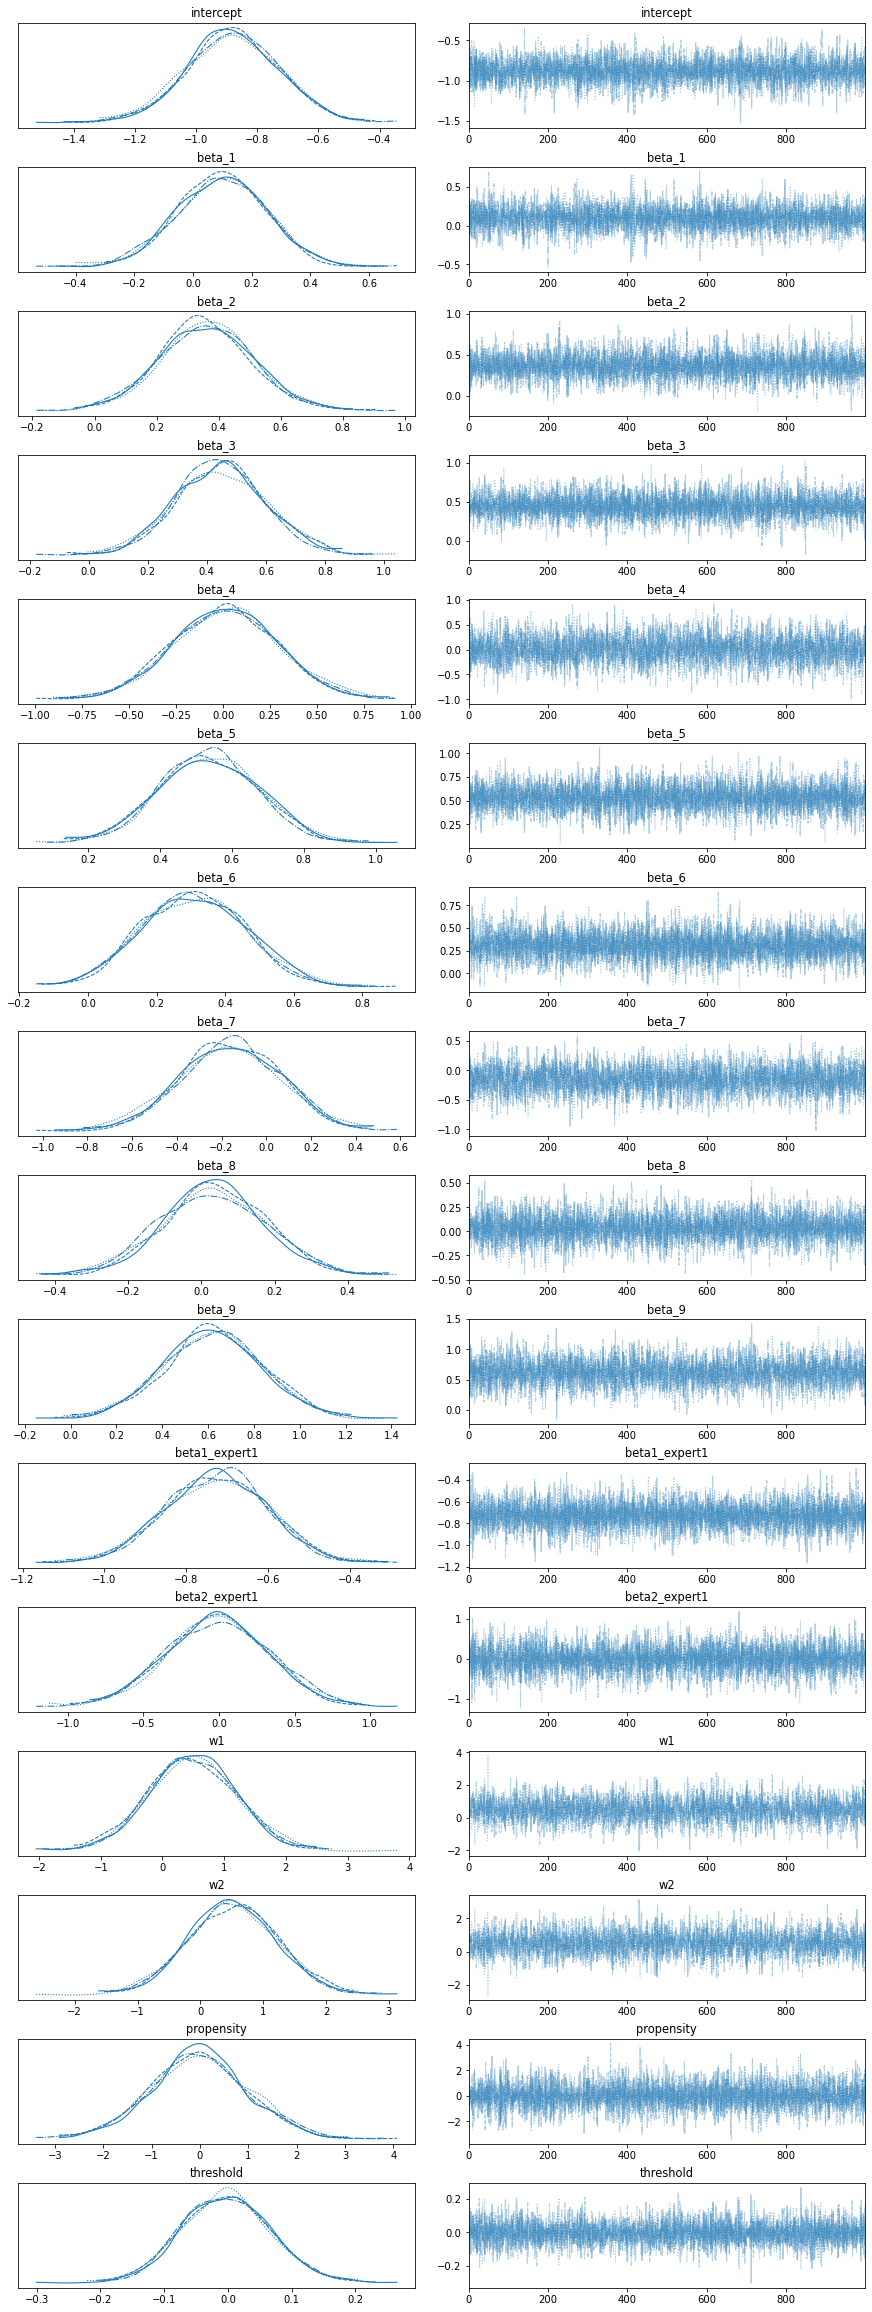

In [42]:
pm.plot_trace(trace);

/Users/parthpahwa/miniconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-1.690,0.827,-3.277,-0.172,0.016,0.011,2701.0,2627.0,2703.0,2564.0,1.0
beta_1,-0.005,0.007,-0.018,0.008,0.000,0.000,2851.0,2168.0,2843.0,2439.0,1.0
beta_2,0.082,0.033,0.019,0.142,0.001,0.000,3199.0,2829.0,3242.0,2574.0,1.0
beta_3,0.230,0.082,0.081,0.386,0.001,0.001,3853.0,3616.0,3850.0,2979.0,1.0
beta_4,0.037,0.036,-0.032,0.102,0.001,0.001,2266.0,2082.0,2275.0,2758.0,1.0
beta_5,1.062,0.277,0.580,1.617,0.004,0.003,3852.0,3734.0,3855.0,2768.0,1.0
beta_6,0.011,0.013,-0.014,0.035,0.000,0.000,3157.0,2370.0,3156.0,2789.0,1.0
beta_7,-0.117,0.055,-0.216,-0.014,0.001,0.001,2336.0,2235.0,2346.0,2405.0,1.0
beta_8,0.001,0.005,-0.009,0.012,0.000,0.000,2853.0,1903.0,2861.0,2577.0,1.0
beta_9,0.028,0.013,0.004,0.054,0.000,0.000,2569.0,2569.0,2569.0,2714.0,1.0


In [4]:
import scipy

class Expert:
    def __init__(self, clf, feature_name):
        self.name = feature_name
        self.clf = clf
        self.features = list(feature_name)
        self.priors = self.initialize_priors()
    
    def initialize_priors(self):
        return [scipy.stats.norm(0,1), scipy.stats.norm(0,1)]
    
    def update_prior(mean0, mean1):
        self.priors = [scipy.stats.norm(mean0,1), scipy.stats.norm(mean1,1)]
        
    def get_prior_for_patient(self, data):
        index = clf.predict(data[self.features])
        return self.priors[index]


class Model:
    def __init__(self, data, feature_name, prediction):
        self.name = feature_name
        self.clf = clf
        self.features = list(feature_name)
        self.priors = self.initialize_priors()
    
    def initialize_priors(self):
        return [scipy.stats.norm(0,1), scipy.stats.norm(0,1)]
    
    def update_prior(mean0, mean1):
        self.priors = [scipy.stats.norm(mean0,1), scipy.stats.norm(mean1,1)]
        
    def get_prior_for_patient(self, data):
        index = clf.predit(data[self.features])
        return self.priors[index]


In [4]:
df['Tree_'+str(pair)] = clf.predict(df[[pair[0], pair[1]]])
df.groupby('Tree_'+str(pair)).mean()[[pair[0], pair[1]]]

,alcohol,age
"Tree_('alcohol', 'age')",,
0,17.068651,34.388889
1,16.657563,57.837500


In [14]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)
    beta_3 = pm.Normal('beta_3', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 * data.duration + beta_2 * data.pdays + beta_3 * data.previous)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=data.deposit)

INFO (theano.gof.compilelock): Refreshing lock /Users/parthpahwa/.theano/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.10.9-64/lock_dir/lock


NameError: name 'data' is not defined

In [12]:
import pymc3 as pm

AttributeError: module 'arviz' has no attribute 'geweke'

In [23]:
help(Xt)

Help on SharedVariable in module pytensor.compile.sharedvalue object:

class SharedVariable(pytensor.graph.basic.Variable)
 |  SharedVariable(type: 'Type', value, strict: bool, allow_downcast=None, container: Optional[pytensor.link.basic.Container] = None, name: Optional[str] = None)
 |  
 |  Variable that is shared between compiled functions.
 |  
 |  Method resolution order:
 |      SharedVariable
 |      pytensor.graph.basic.Variable
 |      pytensor.graph.basic.Node
 |      pytensor.graph.utils.MetaObject
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, type: 'Type', value, strict: bool, allow_downcast=None, container: Optional[pytensor.link.basic.Container] = None, name: Optional[str] = None)
 |      Parameters
 |      ----------
 |      type
 |          The `Type` for this variable (see `Variable`).
 |      value
 |          A value to associate with this variable (a new container will be
 |          created).
 |      strict
 |

,alcohol,age
"Tree_('alcohol', 'age')",,
2,12.373043,22.173913
3,19.768625,41.412500
5,15.413797,57.854430
6,114.915000,56.500000


,alcohol,age
"Tree_('alcohol', 'age')",,
0,17.068651,34.388889
1,16.657563,57.837500


[Text(0.5, 0.8333333333333334, 'age <= 50.5\ngini = 0.459\nsamples = 100.0%\nvalue = [0.643, 0.357]\nclass = No'),
 Text(0.25, 0.5, 'age <= 30.5\ngini = 0.35\nsamples = 61.2%\nvalue = [0.774, 0.226]\nclass = No'),
 Text(0.125, 0.16666666666666666, 'gini = 0.141\nsamples = 22.3%\nvalue = [0.924, 0.076]\nclass = No'),
 Text(0.375, 0.16666666666666666, 'gini = 0.43\nsamples = 38.8%\nvalue = [0.688, 0.312]\nclass = No'),
 Text(0.75, 0.5, 'alcohol <= 108.9\ngini = 0.492\nsamples = 38.8%\nvalue = [0.438, 0.562]\nclass = Yes'),
 Text(0.625, 0.16666666666666666, 'gini = 0.494\nsamples = 38.3%\nvalue = [0.443, 0.557]\nclass = Yes'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 0.5%\nvalue = [0.0, 1.0]\nclass = Yes')]

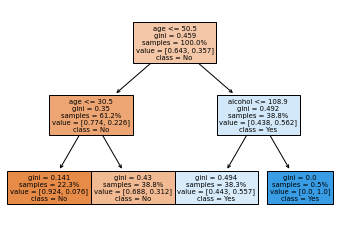

In [66]:

tree.plot_tree(clf, feature_names = pair, class_names=['No','Yes'], filled = True, proportion=True)


In [50]:
clf.tree_.feature

array([ 1,  1, -2, -2,  0, -2, -2], dtype=int64)

In [ ]:
class Propensity:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def get_propernsity_score:
        return mean + std*np.random.standard_normal(1)[0]
    
class Threshold:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def get_propernsity_score:
        return mean + std*np.random.standard_normal(1)[0]
    
    
def get_treatment_tolerence(propensity=None, threshold=None):
    propensity_score = propensity.get_propernsity_score()
    threshold_score = threshold.get_threshold_score()

    return 1 if propensity_score > threshold_score else 0